In [1]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini"

In [2]:
# 検索ツールの定義
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [3]:
tool.invoke("Langgraphのノードとは？")

[{'url': 'https://zenn.dev/pharmax/articles/8796b892eed183',
  'content': 'コンポーネント | 説明\nGraph | LangGraphの中核となる構成要素で、各NodeとEdgeの集合体です。\nState | ノード間の遷移の際に保持される情報で、各ノードが参照および更新します。\nNode | グラフ内の個々のステップや状態を表す要素で、特定のアクションやチェックポイントとして機能します。\nEdge | ノード間の接続を表し、遷移の条件やアクションを定義します。条件付きエッジなど、特定のロジックに基づいて遷移を制御できます。\nGraph\n\nGraphは、LangGraphの中核となるグラフ全体を管理するためのコンポーネントです。基本的な使い方としては、StateGraphというクラスを使い、後述するStateとセットで初期化します。\n\n（StateGraphの宣言例）\n\nState\n\nStateは、Graph内のNodeやEdgeに渡される状態のオブジェクトです。\n\nStateには、typingモジュールの「TypeDict」または「PydanticのBaseModel」が使用できます。\n\n以下は、TypeDictを継承したStateの例です。 [...] Reducers\n\nStateは、reducerと呼ばれる関数と一緒に使用することもできます。reducerは、状態を更新するための関数で、(現在の値、追加される値) -> 状態を更新する値のシグネチャを持ちます。\n\nreducerを使用することで、状態の更新時に特定のロジックを介することが可能になります。\n\nNode\n\nNodeは、Graph上で実際のステップを実行するコンポーネントです。例えば実際にLangChainを使用してLLMのモデルを呼び出す処理は、Node上で行います。\n\nNodeでは、(State、Config) -> 変更するStateというシグネチャを持つ関数を使うことができます。\n\ngraphに対して add_node というメソッドを使用して、nodeを紐づけます。第一引数は、Nodeに対して任意のpath名を文字列で指定できます。\n\nEdge\n\nE

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# Stateクラスの定義
class State(TypedDict):
    messages: Annotated[list, add_messages]

# グラフのインスタンスを作成
graph_builder = StateGraph(State)

# 言語モデルの定義
llm = ChatOpenAI(model_name=MODEL_NAME)

# 変更点：ツール定義の紐づけ
llm_with_tools = llm.bind_tools(tools)

# チャットボットノードの作成
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# グラフにチャットボットノードを追加
graph_builder.add_node("chatbot", chatbot)

In [5]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# ツールノードの作成
tool_node = ToolNode(tools)

# グラフにツールノードを追加
graph_builder.add_node("tools", tool_node)

# 条件付エッジの作成
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition, # ツール呼出と判断したらツールノードを呼ぶ
)

# ツールが呼び出されるたびに、チャットボットに戻って次のステップを決定
# ツールからチャットボットへの戻りエッジを作成
graph_builder.add_edge("tools", "chatbot")

# 開始ノードの指定
graph_builder.set_entry_point("chatbot")

# 記憶を持つ実行可能なステートグラフの作成
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

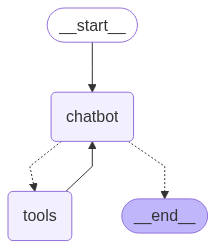

In [6]:
# グラフの可視化
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    events = graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    stream_graph_updates(user_input)

こんにちは！
こんにちは！今日はどんなことをお手伝いできますか？
1足す2は？
1足す2は3です。ほかに何かお手伝いできることはありますか？
1メートル以上の魚は？

[{"url": "http://cms.town.wakayama-hidaka.lg.jp/docs/2014090300054/", "content": "少々いかつい顔をしたこの“どでかい魚”、名前はクエ。 大きいものでは、体長1メートル以上にも達する大型魚です。関東以南の太平洋沿岸から東シナ海沿岸にかけての温かい海"}, {"url": "https://detail.chiebukuro.yahoo.co.jp/qa/question_detail/q14260099909", "content": "友人と琵琶湖でバス釣りをしていたら、余裕で1m以上の巨大な魚を見ました。かなり近くで見たのですが、ビワコオオナマズでも、コイでもありません。"}]
1メートル以上の魚にはいくつかの種類があります。例えば、以下の魚が挙げられます：

1. **クエ** - この魚は体長1メートル以上に成長することがあります。主に関東以南の太平洋沿岸や東シナ海沿岸に生息しています。詳しい情報は[こちら](http://cms.town.wakayama-hidaka.lg.jp/docs/2014090300054/)で確認できます。

2. **ビワコオオナマズ** - これは琵琶湖に生息する大きなナマズで、1メートルを超えるものも見られます。友人が釣りをしている際に目撃したという事例もあります。

他にも1メートル以上の魚は多く存在しますが、特に有名なものとしてはこれらがあります。興味がある魚についてもっと知りたいことがあれば教えてください！
ありがとうございました!
